# Recuperación ranqueada y vectorización de documentos

In [ ]:
import pandas as pd
import numpy as np
from typing import List
from gensim import corpora, models
from gensim.similarities import MatrixSimilarity
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize
from nltk.stem import SnowballStemmer
import matplotlib.pyplot as plt
import os
from typing import Dict, Any
import numpy as np
import seaborn as sns

In [200]:

PATH_TO_DATA = "data/"
PATH_TO_RESULTS = "results/"

docs_raw_path = f"{PATH_TO_DATA}docs-raw-texts/"
queries_raw_path = f"{PATH_TO_DATA}queries-raw-texts/"
judgments_file = f"{PATH_TO_DATA}relevance-judgments.tsv"
bsii_results_file = f"{PATH_TO_RESULTS}BSII-AND-queries_results.tsv"
rrdv_results_file = f"{PATH_TO_RESULTS}RRDV-consultas_resultados.tsv"
gensim_results_file = f"{PATH_TO_RESULTS}GENSIM-consultas_resultados.tsv"



## Funciones necesarias del punto anterior

In [201]:
def precision_at_k(relevance_query: List[int], k: int) -> float:
    """
    Calcula la precision en el top-k de una consulta dada una lista de relevancia binaria
    Args:
        relevance_query (List[int]): Lista de relevancia binaria (1=relevante, 0=no relevante)
        k (int): Número de elementos a considerar en el top-k
    Returns:
        float: Precision en el top-k de la consulta
    """
    if k <= 0:
        raise ValueError("k debe ser un entero positivo menor o igual al tamaño de la lista de relevancia")
    
    relevance_query = np.array(relevance_query)[:k]
    return np.mean(relevance_query)

In [202]:
def recall_at_k(relevance_query: List[int], number_relevant_docs: int,  k: int) -> float:
    """
    Calcula la recall en el top-k de una consulta dada una lista de relevancia binaria
    Args:
        relevance_query (List[int]): Lista de relevancia binaria (1=relevante, 0=no relevante)
        number_relevant_docs (int): Número total de documentos relevantes
        k (int): Número de elementos a considerar en el top-k
    Returns:
        float: Recall en el top-k de la consulta
    """
    if k <= 0:
        raise ValueError("k debe ser un entero positivo menor o igual al tamaño de la lista de relevancia")
    if number_relevant_docs <= 0:
        raise ValueError("El número de documentos relevantes debe ser un entero positivo")
        
    relevance_query = np.array(relevance_query)[:k]
    return np.sum(relevance_query) / number_relevant_docs
    

In [203]:
def average_precision(relevance_query: List[int]) -> float:
    """
    Calcula la precisión promedio de una consulta dada una lista de relevancia binaria
    Args:
        relevance_query (List[int]): Lista de relevancia binaria (1=relevante, 0=no relevante)
    Returns:
        float: Precisión promedio de la consulta
    """
    relevance_query = np.array(relevance_query)
    cumulative_precision = 0.0
    for i in range(len(relevance_query)):
        if relevance_query[i] == 1:
            cumulative_precision += precision_at_k(relevance_query, i + 1)
    if np.sum(relevance_query) == 0:
        return 0.0
    return cumulative_precision / np.sum(relevance_query)

In [204]:
def mean_average_precision(relevance_queries: List[List[int]]) -> float:
    """
    Calcula la precisión promedio de un conjunto de consultas
    Args:
        relevance_queries (List[List[int]]): Lista de listas de relevancia binaria
    Returns:
        float: Precisión promedio de todas las consultas
    """
    return np.mean([average_precision(query) for query in relevance_queries])

In [205]:
def dcg_at_k(relevance_scores: List[int], k: int) -> float:
    """
    Calcula el Discounted Cumulative Gain (DCG) en la posición k
    Args:
        relevance_scores (List[int]): Lista de relevancia (1=relevante, 0=no relevante)
        k (int): La posición hasta la cual calcular el DCG
    Returns:
        float: El valor del DCG en la posición k
    """
    relevance_scores = np.array(relevance_scores)[:k]
    positions = np.arange(1, len(relevance_scores) + 1)
    discounts = np.log2(np.maximum(positions, 2))
    dgc = np.sum(relevance_scores / discounts)
    return dgc

In [206]:
def ndcg_at_k(relevance_scores: List[int], k: int) -> float:
    """
    Calcula el Normalized Discounted Cumulative Gain (NDCG) en la posición k
    Args:
        relevance_scores (List[int]): Lista de relevancia (1=relevante, 0=no relevante)
        k (int): La posición hasta la cual calcular el NDCG
    Returns:
        float: El valor del NDCG en la posición k
    """
    dcg = dcg_at_k(relevance_scores, k)
    ideal_relevance = np.sort(relevance_scores)[::-1][:k]
    idcg = dcg_at_k(ideal_relevance, k)
    if idcg == 0:
        return 0.0
    return dcg / idcg

In [207]:
def normalize_text(text: str) -> str:
    """
    Normaliza el texto eliminando caracteres no deseados y convirtiendo a minúsculas.

    Args:
        text (str): El texto a normalizar.

    Returns:
        str: El texto normalizado.
    """
    text = text.strip().lower()
    text = re.sub(r"\s+", " ", text)  # Reemplaza múltiples espacios por uno solo
    text = re.sub(r'\[\d+\]', '', text)  # Elimina referencias numéricas
    return text

In [208]:
def tokenize_text(text: str) -> List[str]:
    """
    Tokeniza el texto en una lista de tokens utilizando expresiones regulares.

    Args:
        text (str): El texto a tokenizar.

    Returns:
        List[str]: La lista de tokens.
    """
    text = normalize_text(text)
    pattern = r'''(?x)
        (?:[A-Z]\.)+[A-Z]?                      # abreviaturas: U.S.A, U.S.A.
    | [A-Za-z]+(?:-[A-Za-z]+)*                  # palabras con guiones
    | [A-Za-z]+(?:'[A-Za-z]+)?                  # contracciones: don't, we're
    | \$?\d+(?:\.\d+)?%?                        # números simples
    | \.\.\.                                    # puntos suspensivos
    | [\[\].,;"'?():_`!-]                       # puntuación expandida
    '''
    tokens = nltk.regexp_tokenize(text, pattern)
    return tokens


In [209]:
def remove_stopwords(tokens: List[str]) -> List[str]:
    """
    Elimina las stopwords de una lista de tokens.

    Args:
        tokens (List[str]): La lista de tokens a procesar.

    Returns:
        List[str]: La lista de tokens sin stopwords.
    """
    stop_words = set(stopwords.words("english"))
    return [token for token in tokens if token not in stop_words]

In [210]:
def stem_tokens(tokens: List[str]) -> List[str]:
    """
    Aplica stemming a una lista de tokens.

    Args:
        tokens (List[str]): La lista de tokens a procesar.

    Returns:
        List[str]: La lista de tokens con stemming aplicado.
    """
    stemmer = SnowballStemmer("english")
    return [stemmer.stem(token) for token in tokens]


In [211]:
def preprocess_text(text: str) -> List[str]:
    """
    Preprocesa el texto aplicando normalización, tokenización, eliminación de stopwords y stemming.

    Args:
        text (str): El texto a preprocesar.

    Returns:
        List[str]: La lista de tokens preprocesados.
    """
    tokens = tokenize_text(text)
    tokens = remove_stopwords(tokens)
    tokens = stem_tokens(tokens)
    return tokens

In [212]:
from pathlib import Path
import xml.etree.ElementTree as ET

def load_naf_data(dir_naf:str) -> dict:
    """
    Carga los datos en formato NAF desde un directorio dado.
    Para cada documento se concatena el título y el texto en bruto.
    Luego de eso se procesa el texto, se tokeniza y se devuelve.

    Args:
        dir_naf (str): El directorio que contiene los archivos NAF.

    Returns:
        dict: Un diccionario con los IDs de los documentos como claves y listas de tokens como valores.
    """
    dirp = Path(dir_naf)
    out = {}
    for naf_path in sorted(dirp.glob("*.naf")):
        root = ET.parse(naf_path).getroot()
        public_id = root.find("./nafHeader/public").attrib["publicId"].strip()
        title = root.find("./nafHeader/fileDesc").attrib["title"].strip()
        raw_text = root.find("raw").text
        payload = raw_text[9:-3].strip()
        combinado = f"{title} {payload}"
        tokens = preprocess_text(combinado)
        out[public_id] = tokens

    return out

In [213]:
documents = load_naf_data(docs_raw_path)

In [214]:
def create_binary_relevance_list(retrieved_docs: List[str], relevant_docs: Dict[str, int]) -> List[int]:
    """
    Convierte lista de docs recuperados a vector binario
    1 si el doc es relevante (está en relevance judgments), 0 si no
    """
    return [1 if doc_id in relevant_docs else 0 for doc_id in retrieved_docs]

def create_graded_relevance_list(retrieved_docs: List[str], relevant_docs: Dict[str, int]) -> List[int]:
    """
    Convierte lista de docs recuperados a vector con grados de relevancia
    Usa el grado del relevance judgment, 0 si no está
    """
    return [relevant_docs.get(doc_id, 0) for doc_id in retrieved_docs]

def load_relevance_judgments(file_path: str) -> Dict[str, Dict[str, int]]:
    """
    Carga relevance judgments del archivo TSV

    Args:
        file_path: Ruta al archivo TSV

    Returns:
        Dict[str, Dict[str, int]]: Mapa de relevancia
    """
    relevance_data = {}
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split('\t')
            query_id = parts[0]
            
            doc_relevances = {}
            if len(parts) > 1:  # Si hay documentos relevantes
                doc_pairs = parts[1].split(',')
                for pair in doc_pairs:
                    doc_id, grade = pair.split(':')
                    doc_relevances[doc_id] = int(grade)
            
            relevance_data[query_id] = doc_relevances
    
    return relevance_data

def load_tfidf_results(file_path: str) -> Dict[str, List[str]]:
    """
    Carga resultados TF-IDF del archivo
    Returns: {query_id: [doc_ids_ordenados_por_similaridad]}
    """
    results = {}
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split('\t')
            query_id = parts[0]
            
            doc_list = []
            if len(parts) > 1:  # Si hay resultados
                doc_pairs = parts[1].split(',')
                for pair in doc_pairs:
                    doc_id = pair.split(':')[0]  # Solo el doc_id, ignorar similaridad
                    doc_list.append(doc_id)
            
            results[query_id] = doc_list
    
    return results

In [215]:
def evaluate_tfidf_system(
    tfidf_results_file: str,
    relevance_judgments_file: str
):
    """
    Evalúa sistema TF-IDF calculando P@M, R@M, NDCG@M por consulta y MAP global


    Args:
    tfidf_results_file: Ruta al archivo de resultados TF-IDF
    relevance_judgments_file: Ruta al archivo de juicios de relevancia
    output_file: Ruta al archivo de salida para los resultados de evaluación
    """
    
    # 1. Cargar datos
    relevance_data = load_relevance_judgments(relevance_judgments_file)
    tfidf_results = load_tfidf_results(tfidf_results_file)
    
    query_evaluations = {}
    average_precisions = []
    
    # 2. Evaluar cada consulta
    for query_id, relevant_docs in relevance_data.items():
        M = len(relevant_docs)  # Número de docs relevantes para esta consulta
        
        # Obtener docs recuperados por TF-IDF (ordenados por similaridad)
        retrieved_docs = tfidf_results.get(query_id, [])
        
        # Crear vectores de relevancia
        binary_relevance = create_binary_relevance_list(retrieved_docs, relevant_docs)
        graded_relevance = create_graded_relevance_list(retrieved_docs, relevant_docs)
        
        # Calcular métricas
        precision_m = precision_at_k(binary_relevance, M)
        recall_m = recall_at_k(binary_relevance, M, M)  # M docs relevantes totales
        ndcg_m = ndcg_at_k(graded_relevance, M)
        avg_precision = average_precision(binary_relevance)
        
        query_evaluations[query_id] = {
            'precision_m': precision_m,
            'recall_m': recall_m, 
            'ndcg_m': ndcg_m,
            'average_precision': avg_precision
        }
        
        average_precisions.append(avg_precision)
    
    # 3. Calcular MAP
    map_score = sum(average_precisions) / len(average_precisions) if average_precisions else 0.0

    # Mostrar resultados
    print("Resultados de evaluación:")
    for query_id, metrics in query_evaluations.items():
        print(f"Consulta {query_id}:")
        for metric_name, value in metrics.items():
            print(f"  {metric_name}: {value:.4f}")
    print(f"MAP: {map_score:.4f}")


## Implementación GenSim

In [216]:
def prepare_gensim_data(processed_documents: Dict[str, List[str]]):
    """
    Convierte documentos tokenizados al formato que espera Gensim.

    Args:
        processed_documents (Dict[str, List[str]]): Documentos procesados y tokenizados.

    Returns:
        Tuple[corpora.Dictionary, List[List[Tuple[int, int]]], List[str]]: Diccionario de Gensim, corpus en formato Bag-of-Words y lista de IDs de documentos.
    """

    documents = list(processed_documents.values())
    doc_ids = list(processed_documents.keys())
    
    dictionary = corpora.Dictionary(documents)
    
    
    corpus = [dictionary.doc2bow(doc) for doc in documents]
    
    return dictionary, corpus, doc_ids

Se puede ver un pequeño ejemplo de la función y cómo queda la información.

In [217]:
dictionary, corpus, doc_ids = prepare_gensim_data(documents)
print("Número de palabras en el diccionario:", len(dictionary))
print("Ejemplo de entradas en el diccionario:")
for word_id in list(dictionary.keys())[:5]:
    print(f"ID: {word_id}, Palabra: {dictionary[word_id]}")
print("-" * 20)
print("Número de documentos:", len(corpus))
print("Primeros 3 documentos del corpus:")
print("Estructura básica del corpus:")
for i in range(min(5, len(corpus))):
    doc = corpus[i]
    print(f"Doc {i}: {len(doc)} términos únicos: {doc}")


Número de palabras en el diccionario: 14304
Ejemplo de entradas en el diccionario:
ID: 0, Palabra: ,
ID: 1, Palabra: -
ID: 2, Palabra: .
ID: 3, Palabra: 1785
ID: 4, Palabra: 1812
--------------------
Número de documentos: 331
Primeros 3 documentos del corpus:
Estructura básica del corpus:
Doc 0: 178 términos únicos: [(0, 20), (1, 1), (2, 29), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 2), (21, 2), (22, 1), (23, 2), (24, 1), (25, 1), (26, 1), (27, 12), (28, 4), (29, 1), (30, 1), (31, 1), (32, 1), (33, 2), (34, 1), (35, 1), (36, 1), (37, 3), (38, 1), (39, 1), (40, 2), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 12), (47, 1), (48, 2), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 3), (57, 1), (58, 2), (59, 1), (60, 1), (61, 1), (62, 2), (63, 2), (64, 1), (65, 3), (66, 1), (67, 1), (68, 5), (69, 1), (70, 1), (71, 2), (72, 3), (73, 1), (74, 1), (75, 1), (76

Como se puede observar, el diccionario y el corpus ahora manejan su propia estructura de datos, donde cada entrada del corpus hace referencia a un ID único en el diccionario. Aparentemente siendo el token ',' (coma) el primero en la bolsa de palabras.

In [218]:
def build_gensim_tfidf_system(processed_documents: Dict[str, List[str]]):
    """
    Construye sistema TF-IDF usando Gensim.
    Primero, se preparan los datos.
    Luego, se crea el modelo TF-IDF y se transforma el corpus.
    Finalmente, se crea un índice de similitud.

    Args:
        processed_documents (Dict[str, List[str]]): Documentos procesados.

    Returns:
        Tuple[Dictionary, TfidfModel, MatrixSimilarity, List[str]]: Elementos del sistema TF-IDF.
    """
    # Preparar datos
    dictionary, corpus, doc_ids = prepare_gensim_data(processed_documents)
    
    # Crear modelo TF-IDF
    tfidf_model = models.TfidfModel(corpus)
    
    # Transformar corpus a TF-IDF
    tfidf_corpus = tfidf_model[corpus]
    
    # Crear índice de similitud
    similarity_index = MatrixSimilarity(tfidf_corpus)
    
    return dictionary, tfidf_model, similarity_index, doc_ids

In [219]:
# Ejecutar tu función
dictionary, tfidf_model, similarity_index, doc_ids = build_gensim_tfidf_system(documents)

print("=== Sistema TF-IDF construido ===")
print(f"Diccionario: {len(dictionary)} términos únicos")
print(f"Corpus original: {len(corpus)} documentos")
print(f"Índice de similitud: {similarity_index.num_features} características")

# Mostrar transformación BOW -> TF-IDF para un documento
print("\n=== Ejemplo de transformación BOW -> TF-IDF ===")
doc_ejemplo = 20
print(f"Documento {doc_ejemplo} (ID: {doc_ids[doc_ejemplo]}):")

# BOW original
bow_original = corpus[doc_ejemplo]
print(f"BOW original (primeros 10): {bow_original[:10]}")

# TF-IDF transformado
tfidf_doc = tfidf_model[bow_original]
print(f"TF-IDF (primeros 10): {list(tfidf_doc)[:10]}")


=== Sistema TF-IDF construido ===
Diccionario: 14304 términos únicos
Corpus original: 331 documentos
Índice de similitud: 14304 características

=== Ejemplo de transformación BOW -> TF-IDF ===
Documento 20 (ID: d021):
BOW original (primeros 10): [(0, 44), (1, 1), (2, 33), (13, 2), (18, 1), (22, 1), (28, 1), (33, 2), (40, 3), (48, 3)]
TF-IDF (primeros 10): [(1, 0.004586127729863724), (13, 0.008178673324969056), (18, 0.0052111350072762234), (22, 0.009357891913010495), (28, 0.0018690386742130601), (33, 0.002782225409641234), (40, 0.03349592224557236), (48, 0.01436349893594786), (57, 0.005255028157194065), (58, 0.017275733104547445)]


Es posible observar aquí que GenSim también utiliza una representación esparcida para los documentos y las consultas. GenSim elimina los términos que tengan un peso TF-IDF de cero, y de esta manera ayuda a mantener la eficiencia en la representación de cada documento y posteriormente consulta.

Esto se ve claramente en la salida del ejemplo de consulta, donde el término con ID 0 (",") no aparece en el resultado TF-IDF.


In [220]:
def process_query_with_gensim(query_tokens: List[str], dictionary, tfidf_model):
    """
    Convierte consulta a vector TF-IDF usando Gensim. Este recibe los tokens de la consulta,
    ya procesados bajo los estándares establecidos.DirEntry

    Args:
        query_tokens (List[str]): Tokens de la consulta.
        dictionary: Diccionario Gensim.
        tfidf_model: Modelo TF-IDF Gensim.

    Returns:
        List[Tuple[int, float]]: Vector TF-IDF de la consulta.
    """
    # Convertir consulta a BOW
    query_bow = dictionary.doc2bow(query_tokens)
    
    # Aplicar modelo TF-IDF
    query_tfidf = tfidf_model[query_bow]
    
    return query_tfidf

In [221]:
def process_gensim_queries(
    documents_dir: str,
    queries_folder: str, 
    output_file: str
):
    """
    Procesa todas las consultas usando Gensim TF-IDF
    """
    # 1. Cargar documentos
    processed_documents = load_naf_data(documents_dir)
    
    # 2. Construir sistema TF-IDF con Gensim
    dictionary, tfidf_model, similarity_index, doc_ids = build_gensim_tfidf_system(processed_documents)
    
    # 3. Procesar consultas - QUITAR las líneas de makedirs
    with open(output_file, 'w') as f:
        query_files = sorted([file for file in os.listdir(queries_folder) if file.endswith('.naf')])
        
        for query_file in query_files:
            # Parse consulta NAF
            tree = ET.parse(os.path.join(queries_folder, query_file))
            raw_content = tree.find('.//raw').text.strip()
            public_id = tree.find('.//public').get('publicId')
            
            query_tokens = preprocess_text(raw_content)
            
            query_tfidf = process_query_with_gensim(query_tokens, dictionary, tfidf_model)
            
            similarities = similarity_index[query_tfidf]
            
            doc_similarities = []
            for i, sim in enumerate(similarities):
                if sim > 0:
                    doc_similarities.append((doc_ids[i], float(sim)))
            
            # Ordenar por similitud descendente
            doc_similarities.sort(key=lambda x: x[1], reverse=True)
            
            if doc_similarities:
                result_pairs = [f"{doc_id}: {sim:.4f}" for doc_id, sim in doc_similarities]
                f.write(f"{public_id}\t{','.join(result_pairs)}\n")
            else:
                f.write(f"{public_id}\n")

In [222]:
process_gensim_queries(
    documents_dir=docs_raw_path,
    queries_folder=queries_raw_path,
    output_file=gensim_results_file
)

In [224]:
evaluate_tfidf_system(
    tfidf_results_file=gensim_results_file,
    relevance_judgments_file=judgments_file
)

Resultados de evaluación:
Consulta q01:
  precision_m: 0.3333
  recall_m: 0.3333
  ndcg_m: 0.3992
  average_precision: 0.7000
Consulta q02:
  precision_m: 0.5455
  recall_m: 0.5455
  ndcg_m: 0.6011
  average_precision: 0.6638
Consulta q03:
  precision_m: 1.0000
  recall_m: 1.0000
  ndcg_m: 0.9846
  average_precision: 1.0000
Consulta q04:
  precision_m: 0.7143
  recall_m: 0.7143
  ndcg_m: 0.7753
  average_precision: 0.8690
Consulta q06:
  precision_m: 0.6667
  recall_m: 0.6667
  ndcg_m: 0.8054
  average_precision: 0.8552
Consulta q07:
  precision_m: 0.2500
  recall_m: 0.2500
  ndcg_m: 0.2606
  average_precision: 0.2123
Consulta q08:
  precision_m: 0.6667
  recall_m: 0.6667
  ndcg_m: 0.7472
  average_precision: 0.7596
Consulta q09:
  precision_m: 0.8333
  recall_m: 0.8333
  ndcg_m: 0.8879
  average_precision: 0.9333
Consulta q10:
  precision_m: 0.3750
  recall_m: 0.3750
  ndcg_m: 0.3044
  average_precision: 0.2800
Consulta q12:
  precision_m: 1.0000
  recall_m: 1.0000
  ndcg_m: 0.9584
  

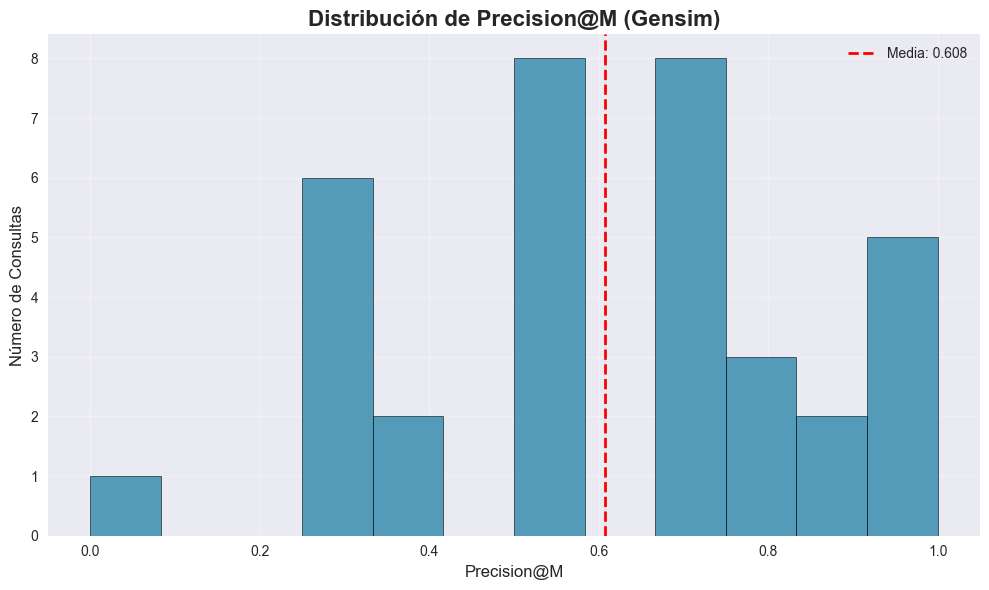

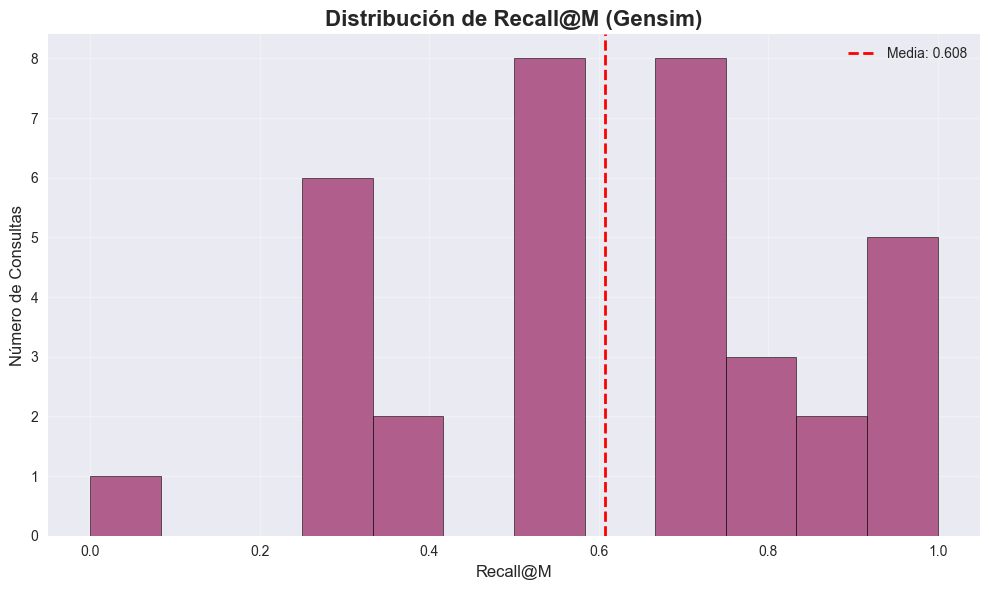

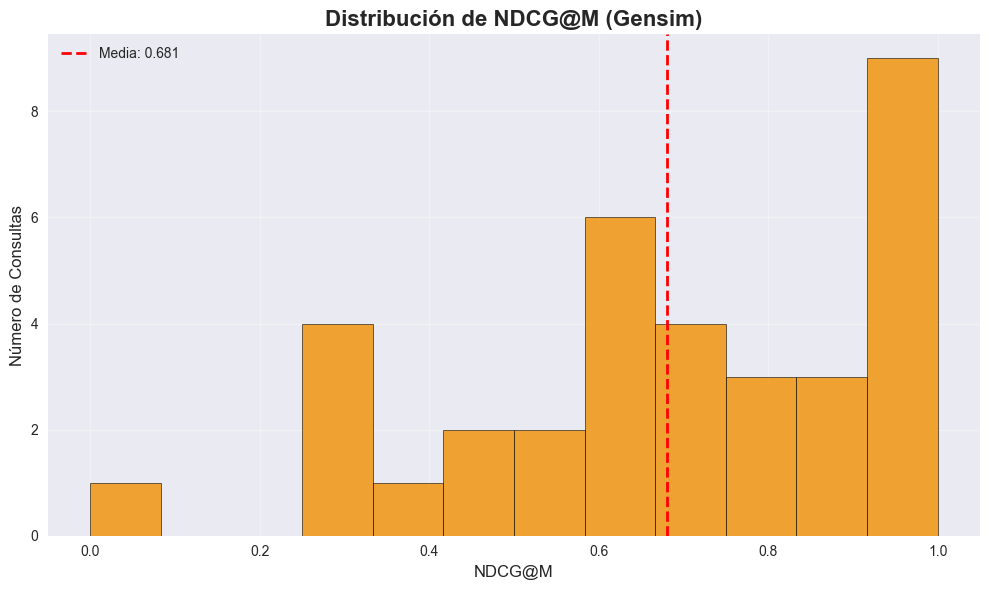

C:\Users\user\AppData\Local\Temp\ipykernel_29140\4251371712.py:58: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data, labels=labels, patch_artist=True, showmeans=True)


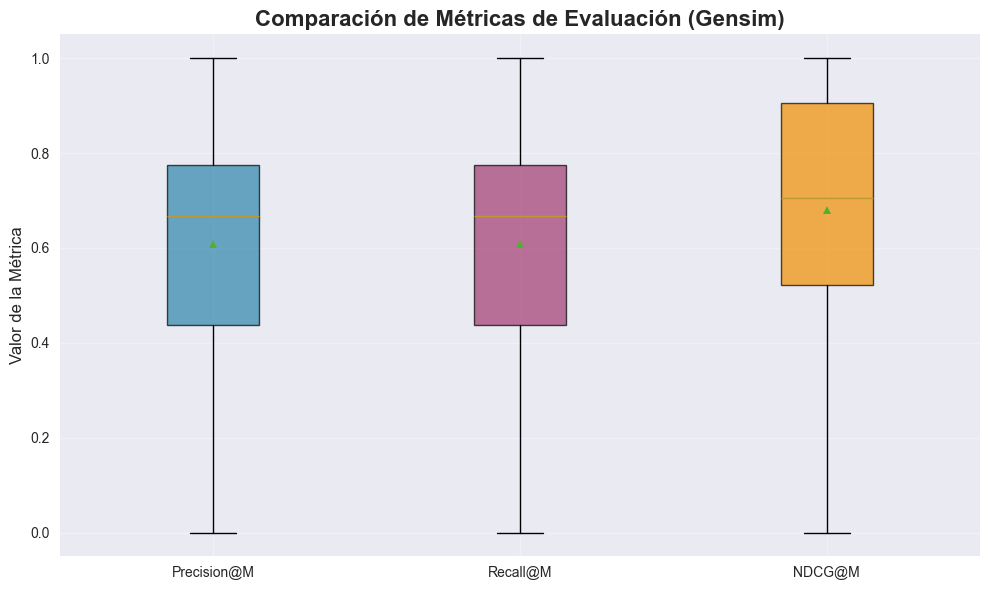

Estadísticas de Gensim:
MAP: 0.6760
Precision@M - Media: 0.6079, Desv: 0.2513
Recall@M - Media: 0.6079, Desv: 0.2513
NDCG@M - Media: 0.6807, Desv: 0.2584


In [ ]:
# Configuración de estilo
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Datos de Gensim
precision_values = [0.3333, 0.5455, 1.0000, 0.7143, 0.6667, 0.2500, 0.6667, 0.8333, 0.3750, 1.0000, 0.8000, 0.5833, 0.5000, 0.5000, 0.7143, 0.5000, 0.5714, 0.2500, 0.0000, 0.5000, 1.0000, 0.3750, 0.6667, 0.7500, 1.0000, 1.0000, 0.7000, 0.6667, 0.2500, 0.6667, 0.8571, 0.3333, 0.5000, 0.8750, 0.3333]

recall_values = [0.3333, 0.5455, 1.0000, 0.7143, 0.6667, 0.2500, 0.6667, 0.8333, 0.3750, 1.0000, 0.8000, 0.5833, 0.5000, 0.5000, 0.7143, 0.5000, 0.5714, 0.2500, 0.0000, 0.5000, 1.0000, 0.3750, 0.6667, 0.7500, 1.0000, 1.0000, 0.7000, 0.6667, 0.2500, 0.6667, 0.8571, 0.3333, 0.5000, 0.8750, 0.3333]

ndcg_values = [0.3992, 0.6011, 0.9846, 0.7753, 0.8054, 0.2606, 0.7472, 0.8879, 0.3044, 0.9584, 0.7178, 0.4844, 0.6000, 0.7044, 0.8553, 1.0000, 0.6312, 0.6037, 0.0000, 0.6747, 1.0000, 0.6568, 0.8087, 0.9425, 1.0000, 1.0000, 0.5013, 1.0000, 0.2677, 0.5426, 0.9230, 0.6052, 0.4257, 0.8745, 0.2821]

# Gráfica 1: Precision@M
plt.figure(figsize=(10, 6))
plt.hist(precision_values, bins=12, alpha=0.8, color='#2E86AB', edgecolor='black', linewidth=0.5)
plt.axvline(np.mean(precision_values), color='red', linestyle='--', linewidth=2, label=f'Media: {np.mean(precision_values):.3f}')
plt.title('Distribución de Precision@M (Gensim)', fontsize=16, fontweight='bold')
plt.xlabel('Precision@M', fontsize=12)
plt.ylabel('Número de Consultas', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Gráfica 2: Recall@M  
plt.figure(figsize=(10, 6))
plt.hist(recall_values, bins=12, alpha=0.8, color='#A23B72', edgecolor='black', linewidth=0.5)
plt.axvline(np.mean(recall_values), color='red', linestyle='--', linewidth=2, label=f'Media: {np.mean(recall_values):.3f}')
plt.title('Distribución de Recall@M (Gensim)', fontsize=16, fontweight='bold')
plt.xlabel('Recall@M', fontsize=12)
plt.ylabel('Número de Consultas', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Gráfica 3: NDCG@M
plt.figure(figsize=(10, 6))
plt.hist(ndcg_values, bins=12, alpha=0.8, color='#F18F01', edgecolor='black', linewidth=0.5)
plt.axvline(np.mean(ndcg_values), color='red', linestyle='--', linewidth=2, label=f'Media: {np.mean(ndcg_values):.3f}')
plt.title('Distribución de NDCG@M (Gensim)', fontsize=16, fontweight='bold')
plt.xlabel('NDCG@M', fontsize=12)
plt.ylabel('Número de Consultas', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Gráfica 4: Boxplot comparativo
plt.figure(figsize=(10, 6))
data = [precision_values, recall_values, ndcg_values]
labels = ['Precision@M', 'Recall@M', 'NDCG@M']
colors = ['#2E86AB', '#A23B72', '#F18F01']

box = plt.boxplot(data, labels=labels, patch_artist=True, showmeans=True)
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

plt.title('Comparación de Métricas de Evaluación (Gensim)', fontsize=16, fontweight='bold')
plt.ylabel('Valor de la Métrica', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Estadísticas resumidas
print("Estadísticas de Gensim:")
print(f"MAP: 0.6760")
print(f"Precision@M - Media: {np.mean(precision_values):.4f}, Desv: {np.std(precision_values):.4f}")
print(f"Recall@M - Media: {np.mean(recall_values):.4f}, Desv: {np.std(recall_values):.4f}")
print(f"NDCG@M - Media: {np.mean(ndcg_values):.4f}, Desv: {np.std(ndcg_values):.4f}")